In [3]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold


In [4]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

In [27]:
def load_data_cv():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    print(f"Dataset length: {len(dataset)}")
    X, y = dataset, labels
    X = X.astype('float32')
    n_features = (X.shape[1], X.shape[2])
    return X, y, n_features

def load_data():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    print(f"Dataset length: {len(dataset)}")
    X, y = dataset, labels
    # X = X.astype('float32') ########## This is a troublesome line!
    print(type(X[1][1][1]))

    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    n_features = (X_train.shape[1], X_train.shape[2])
    # print(n_features)
    return X, y, X_train, y_train, X_test, y_test, n_features

def create_model(n_features):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=n_features))
    model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # fit the model
    model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test Accuracy: %.3f' % acc)

    # make predictions
    predictions = model.predict_classes(X_test)
    predictions = predictions.flatten()
    # model.summary()
    return acc, predictions


In [28]:
def get_faulty_predictions(predictions, labels):
    my_list = []
    for i, val in enumerate(predictions):
        if predictions[i] != labels[i]:
            my_list.append(i)
    return my_list

def print_stats(accs):
    print(np.mean(accs))
    print(np.std(accs))

def show_hist(my_list):
    if isinstance(my_list[0], list):
        from itertools import chain
        my_list = list(chain.from_iterable(my_list))
    bins=np.linspace(0,1200,24)
    print(f"Number of elements plotted: {len(my_list)}")
    plt.hist(my_list, bins=bins)
    plt.xlabel("index in dataset (<200 is clean)")
    plt.ylabel("count")
    plt.title("faulty predictions")
    plt.show()

- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

# No Cross-validation

Dataset length: 1200
<class 'numpy.complex128'>
Test Accuracy: 0.992
0.99242425
0.0
Number of elements plotted: 202


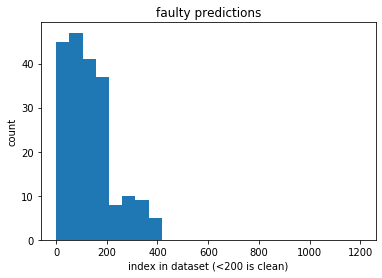

In [29]:
X, y, X_train, y_train, X_test, y_test, n_features = load_data()
faulty_predictions = []
accs = []

model = None
model = create_model(n_features)
acc, predictions = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
accs.append(acc)
faulty_predictions.extend(get_faulty_predictions(predictions, y))

print_stats(accs)
show_hist(faulty_predictions)



## Visualize faulty predictions

0


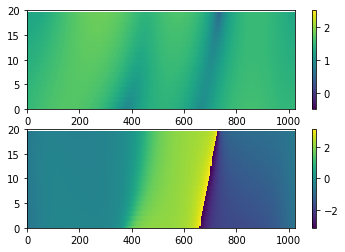

2


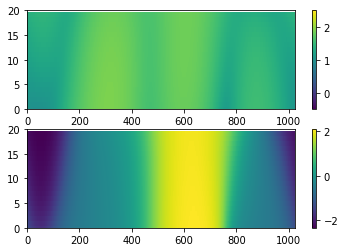

6


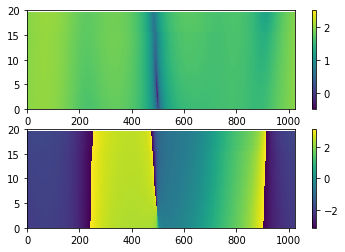

10


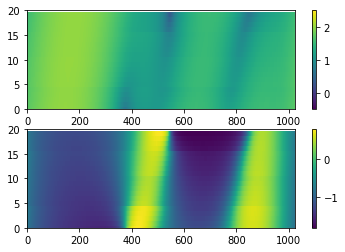

15


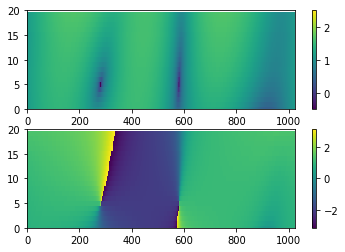

In [31]:
for i, val in enumerate(X):
    if i > 25:
        break
    if i not in faulty_predictions:
        print(i)
        plot_one_vis(val, 20)


In [ ]:
len(X)

In [ ]:
print(len(X))

# Stratified K-fold Cross-validation

In [ ]:
n_splits = 3
X, y, n_features = load_data_cv()
skf = StratifiedKFold(n_splits, shuffle=True)

accs = []
faulty_predictions=[]

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
		# print(len(X[test_index]), len(y[train_index]))
		print("Running Fold", i+1, "/", n_splits)
		model = None # clear the NN
		model = create_model(n_features)
		acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])
		accs.append(acc)
		faulty_predictions.append(get_faulty_predictions(predictions, y))

print_stats(accs)
show_hist(faulty_predictions)